In [39]:
import pandas as pd
from pandas_profiling import ProfileReport

import os
import re

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t')

C:\Users\S053567\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,12,26,27,28,30,51,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.shape

(1524579, 183)

In [4]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

Etant données les dimensions de ce dataset, je vais réaliser l'analyse préliminaire avec Pandas Profiling. L'analyse est exportée en HTML pour une meilleure lisibilité du NB

In [10]:
profile = ProfileReport(data, title="Report on OpenFoodFacts", minimal=True)

In [12]:
profile.to_file('profile_report.html')

# Idee : 
### A partir d'un produit, proposer des produits similaires ayant un emballage meilleur. Appuyer l'analyse par des etudes sur le lien entre l'emballage plastique et les mauvaises caractéristiques nutritionnelles.
## Mieux manger serait-il lié à l'emballage?

Afin de vérifier la faisibilité de cette étude, nous allons déterminer les features necessaires, filtrer les NAN et regarder la taille du dataset filtré

In [82]:
col_necessaires = ['labels_en', 'categories_en', 'packaging_tags', 'additives_n', 'ingredients_from_palm_oil_n', 'nutriscore_score', 'nutriscore_grade']

In [83]:
data_filtre = data.dropna(subset=col_necessaires)

In [84]:
data_filtre.shape

(92575, 183)

Cette quantité a l'air suffisante à première vue

## 1: Analyse bivariée entre le type d'emaballage et le nutriscore_score

In [85]:
X = "packaging_tags" # qualitative
Y = "nutriscore_score" # quantitative

Reduction du nombre de labels

In [86]:
common_packages = data_filtre[X].value_counts().iloc[:10].index
echantillon_1 = data_filtre[data_filtre['packaging_tags'].isin(common_packages)]

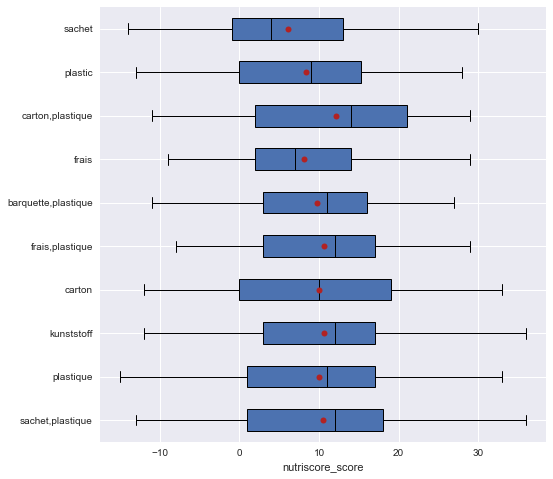

In [87]:
modalites = common_packages
groupes = []
for m in modalites:
    groupes.append(echantillon_1[echantillon_1[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,8))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel(Y)
plt.show()

## 2: Analyse bivariée entre le type d'emaballage et le nutriscore_grade

In [88]:
X = "nutriscore_grade"
Y = "packaging_tags"

echantillon_2 = echantillon_1.copy()
cont = echantillon_2[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len ,margins=True,margins_name="Total")
cont

packaging_tags,"barquette,plastique",carton,"carton,plastique",frais,"frais,plastique",kunststoff,plastic,plastique,sachet,"sachet,plastique",Total
nutriscore_grade,,,,,,,,,,,
a,98,394,178,193,142,306,274,499,344,1006,3434
b,156,273,138,259,168,183,148,277,161,421,2184
c,458,302,173,328,367,369,212,426,258,738,3631
d,499,458,313,549,650,748,371,832,275,1531,6226
e,249,539,422,125,284,414,187,592,117,1183,4112
Total,1460,1966,1224,1454,1611,2020,1192,2626,1155,4879,19587


## Simplification de la données "packaging_tags"

packaging_tags a une trop forte cardinalité

In [89]:
modalities_raw = data_filtre["packaging_tags"].unique()

In [90]:
len(modalities_raw)

18493

J'aimerais le limiter à moins de modalités

In [91]:
modalities_raw[:10]

array(['carton,plastique', 'sachet', 'pot-en-verre,verre',
       'canette,metal', 'sachet,plastique', 'carton', '21-pap', 'papier',
       'squeezer,plastique', 'glas'], dtype=object)

Par exemple à terme il serait interessant d'avoir ce genre de modalités

In [92]:
modalities_simple = ["plastic", "glass", 'cardboard', 'metal', 'paper', ]

## 3: Analyse bivariée entre le type d'emaballage et le nutriscore_grade
### Avec seulement deux catégories plastique/pas de plastique

In [96]:
plastic_test = lambda x : bool(re.search(r'plast', x))

In [97]:
data_filtre["has_plastic"] = data_filtre['packaging_tags'].map(plastic_test)

<ipython-input-97-3631e4e9ff7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre["has_plastic"] = data_filtre['packaging_tags'].map(plastic_test)


In [99]:
data_filtre.has_plastic.value_counts()

True     47185
False    45390
Name: has_plastic, dtype: int64

In [121]:
X = "nutriscore_grade"
Y = "has_plastic"

echantillon_3 = data_filtre[['nutriscore_grade', 'has_plastic']]
cont = echantillon_3[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len ,margins=True,margins_name="Total")

In [122]:
cont['Freq_False'] = cont.loc[:,0] / cont.Total * 100

In [123]:
cont

has_plastic,False,True,Total,Freq_False
nutriscore_grade,,,,
a,8973,8641,17614,50.942432
b,7586,6541,14127,53.698591
c,10117,10042,20159,50.186021
d,11085,13642,24727,44.829539
e,7629,8319,15948,47.836719
Total,45390,47185,92575,49.030516


In [76]:
# allemand_count = 0
# for mod in modalities_raw:
#     pattern = r'plast'
#     match = re.search(pattern, mod)
#     if match:
# #         print(mod)
#         pass
#     else:
#         pattern = r'kunststoff'
#         match = re.search(pattern, mod)
#         if match:
#             print(mod)
#             allemand_count += 1
# print(allemand_count)

kunststoff
karton,kunststoff
kunststoff,schale
pappe,kunststoff
carton,kunststoff
kunststoff,produkt
kunststoffdose
dose,pappe,kunststoff
kunststoff,karton
kunststoff,05-pp,♷
karton,kunststoff,aluminium
dose,kunststoff
kunststoff-tute
21-pap,05-pp,50-for,green-dot,♷,for,pap,pp,50,21,05,05-pp,kunststoff
kunststoff,41-alu,producto
kunststoff,41-alu
06-ps,aluminium,05-pp,kunststoff,♷
07,kunststoff
kunststoff,tute
21-pap,karton,kunststoff
karton,kunststoff,21,pap
kunststoff,pp
tute,kunststoff,07
kunststoff,box
kunststoff,papier
kunststoff,07
kunststoff,07-other
kunststoff,07-o
frais,kunststoff,07
vakuum,kunststoff,07
kunststoff,21,41,06
kunststoff,07-pe,04-ldpe
kunststoff,tute,05,pp
07,kunststoff,schale
21-pap,kunststoff
kunststoff,07-o,folienverpackung
05-pp,kunststoff
kunststoff,05-pp,product
kunststoffbecher
21-pap,82-c-pap,01-pet,pappe,karton,kunststoff
05-pp,♷,41,05,01,pet,alu,pp,kunststoff
packet,kunststoff
21-pap,kunststoff,karton
kartonage,faltschachtel,kunststoff,05-pp
beutel,kuns